## 3D visualisations with nglview

We're probably all familiar with molecular visualisations in PyMol (or a similar molecule viewer). When we've generated a set of molecules using our favourite generative model, often we want to inspect what they might look like in the binding site, to get a sense of whether they're sensible molecules or not. While PyMol is a great tool to have at our disposal, it's generally easier to manipulate objects in the same jupyter notebook we were using to generate the molecules; we're more familiar with python expressions than the PyMol command line, and it's just neater to have everything in one place so we're not constantly writing and reading molecules to and from storage.

nglview is a great tool for this. We can install it by running `conda install -c conda-forge nglview` in the command line. Just like that, we have a 3D molecule viewer that can be run inside a jupyter notebook!

Below, we'll show a couple of use-cases for nglview. More information can be found [here](https://github.com/nglviewer/nglview).



In [1]:
%config Completer.use_jedi = False

import nglview
from ipywidgets import interactive, VBox
import time

#RDKit stuff
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.QED import qed

import pandas as pd

### Viewing a file from the PDB

This one is very simple

In [2]:
pdb_id = "6ooy" #The PDB id we want to look at
view = nglview.show_pdbid(pdb_id)  
view #Use the mouse to manipulate the image

NGLWidget()

### View the protein as a surface


In [3]:
view_surface = nglview.show_pdbid(pdb_id)
view_surface.remove_cartoon()
view_surface.add_surface(opacity = 0.5)
view_surface

NGLWidget()

### Viewing a pdb file we have saved

This one is equally simple

In [2]:
pdb_file = "3acw_protein.pdb" #The PDB file we want to look at
view = nglview.show_file(pdb_file)  
view #Use the mouse to manipulate the image

NGLWidget()

We can use the `show_file` function to show a variety of different file formats

In [3]:
sdf_file = "3acw_ligand.sdf"
view = nglview.show_file(sdf_file)  
view #Use the mouse to manipulate the image

NGLWidget()

### Viewing the Top N molecules generated by a generative model

Now let's imagine that we'd generated and docked a set of molecules using a generative model and we wanted to inspect the best ones in the binding site

In [6]:
n = 15

mols = Chem.SDMolSupplier('elabs.sdf')
mols = [x for x in mols]

score = [qed(x) for x in mols] #Pretend this is some sort of meaningful score for each molecule.

mol_df = pd.DataFrame({'mol':mols, 'score':score}).sort_values('score', ascending = False)
mols_to_visualise = list(mol_df['mol'].head(n))


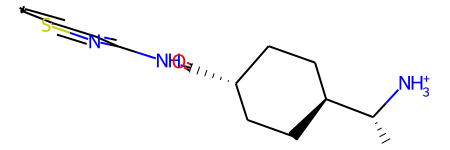

In [7]:
mols_to_visualise[0]

Normally if we try to visualise the 3D molecule using RDKit, we would only get a horrible projection of the molecule (like the one above). We could visualise it in 2D if we used the `RemoveAllConformers()` method, but we'd also like to view it in the context of the binding site.

In [8]:
def show_ligand_in_protein(lig, prot):
    #A function for viewing a 3D RDKit molecule and a pdb file.
    view = nglview.NGLWidget()

    prot_component = view.add_component(prot)
    prot_component.clear()
    prot_component.add_cartoon()
    
    lig_component = view.add_component(lig)
    lig_component.clear()
    lig_component.add_ball_and_stick(multipleBond=True)
    return view

In [9]:
views = [show_ligand_in_protein(x, '1q8t_protein.pdb') for x in mols_to_visualise]

In [10]:
#Now, to visualise each molecule, we simply look at each element of the views, list. e.g.:
views[5]

NGLWidget()

### A better solution

Instead of making lots of different plot objects and storing them in a list, we can also store them all in the same viewer

In [12]:
def load_multiple_ligands(prot_path, mols):
    
    #Add protein
    view = nglview.NGLWidget()
    view.add_component(prot_path)
    
    #Add ligands 
    for idx, m in enumerate(mols):
        view.add_component(m)
        view._ngl_component_names[idx + 1] = f'lig_{idx}'
        
    return view

def load_single_ligand(prot_path, mols, idx):
    
    #Add protein
    view = nglview.NGLWidget()
    view.add_component(prot_path)
    
    #Add ligand 
    
    view.add_component(mols[idx])
    #view._ngl_component_names[idx + 1] = f'lig_{idx}'
        
    return view

class InteractiveViewer():
    
    def __init__(self, prot_path, mols):
        self.view = load_multiple_ligands(prot_path, mols)
        self.prot_path = prot_path
        self.mols = mols
        
        
    def get_component_index(self, component_name):
        """
        Given the name of the loaded file (or a partial string),
        returns the component index if loaded
        """
        all_components = view_test._ngl_component_names
        component_idx = all_components.index([i for i in all_components if component_name in i][0])
        
    def view_specific_ligand(self, lig_identifier):
        
        if lig_identifier == 'All':
            self.view = load_multiple_ligands(self.prot_path, self.mols)
        else:
            self.view = load_single_ligand(self.prot_path, self.mols, lig_identifier)
        
    

In [4]:
int_viewer = InteractiveViewer('1q8t_protein.pdb', mols_to_visualise)

NameError: name 'InteractiveViewer' is not defined

### How to use the box below:

* Run the cell below
* Click on the drop-down list and select the molecule index you want to view
* Rerun the cell and that molecule will be the one showing (even though the displayed value will have gone back to 'All')

There's probably a way to get it to update without rerunning the cell but I haven't figured it out yet.

In [26]:
id_list = ['All'] + list(range(len(int_viewer.mols)))

controls = interactive(int_viewer.view_specific_ligand, 
                       lig_identifier = id_list, 
                       )
VBox([int_viewer.view, controls])